In [1]:
import gurobi as gb
from gurobipy import GRB

import networkx as nx
import numpy as np
import math

# Network model

In [2]:
def init_ring(n):
    """Initializes a graph in ring structure with n nodes
    
    Args: 
        n (int): number of nodes
    
    Returns:
        G (networkx.classes.graph.Graph): Graph in ring structure
    """
    G = nx.Graph()
    for i in range(n): G.add_node(i)
    for i in range(n-1): G.add_edge(i,i+1)
    G.add_edge(0,n-1)
    pos = nx.circular_layout(G)
    nx.draw_networkx(G,pos=pos,with_labels=True)
    return(G)

def init_uniformDemand_matrix(G):
    """Returns a demand matrix, where each peer pair has the same demand in %
    
    Args:
        G (networkx.classes.graph.Graph): 
        
    Returns:
        D (numpy.ndarray): matrix with unformly distributed demands for all node pairs
    
    """
    nodesList = G.nodes
    uniformTraffic = round(1/(len(nodesList)*(len(nodesList)-1)),8)
    D = np.full((len(nodesList),len(nodesList)),uniformTraffic)
    for i in range(len(nodesList)):
        D[i][i] = 0
    return D

def calc_cost(G,D):
    """Returns the cost of traffic on a graph
    
    Args:
        G (networkx.classes.graph.Graph): network graph
        D (numpy.ndarray): Demand Graph
    Returns:
        cost (numpy.ndarray): cost of total traffic between nodes of G
    """
    nodesList = list(G.nodes)
    allShortestPath = nx.shortest_path(G)
    allShortestPathCost = [(len(allShortestPath[i][j])-1)*D[i][j]
                             for i in nodesList for j in nodesList if i!=j]
    return sum(allShortestPathCost)

def SP_edgeList(G,s,t):
    """
    Returns: Shortest Path as list of edge pairs
    """
    allShortestPath = nx.shortest_path(G)
    pathEdgeList = []
    for i in range(len(allShortestPath[s][t])-1):
        pathEdgeList.append((i,allShortestPath[s][t][i+1]))
    return pathEdgeList

def complete_node_pair_list(G):
    """
    Returns: list of all possible outgoin node pairings. One row per node at row index
    """
    nodePairList =[]
    nodes = G.nodes
    for i in G.nodes:
        nodePairList.append([])
        for j in G.nodes:
            nodePairList[i].append((i,j))
    return nodePairList

def complete_node_pair_list_noDuplication(G):
    """
    Returns: list of all possible node pairings without duplication
    """
    nodePairList =[]
    nodes = G.nodes
    for i in G.nodes:
        for j in range(i,len(G.nodes)):
            nodePairList.append((i,j))
    return nodePairList

# Gurobi Optimization
Implementation of the LP, which Arash proposed on 6. June 2022

In [3]:
opt_mod = gb.Model(name="linear programm")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-02


## Setup Network Parameters

/tmp/ipykernel_22400/1601837423.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


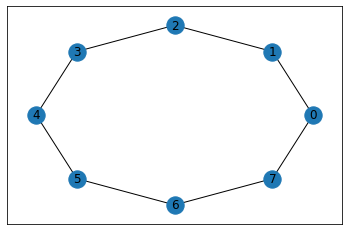

In [4]:
k = 3
G = init_ring(2**k)
D = init_uniformDemand_matrix(G)
adjM = np.full((2**k,2**k),0)
A = nx.adjacency_matrix(G)
allShortestPath = nx.shortest_path(G)
nodesPairList = gb.tuplelist(complete_node_pair_list(G))

## Setting variables

In [5]:
n = len(G.nodes)
edges = gb.tuplelist(G.edges)
nodesPairList = gb.tuplelist(complete_node_pair_list(G))
allShortestPath = nx.shortest_path(G)

# Edges/Links gb.var definition and constraints
e = []
for i in G.nodes:
    e.append([])
    for j in G.nodes:
        e[i].append(opt_mod.addVar(name=f"e_{i,j}", vtype=GRB.BINARY))
opt_mod.update() 

#distance, x, y, flow
dist = []
x = []
flow = []
for i in G.nodes:
    dist.append([])
    x.append([])
    for j in G.nodes:
        dist[i].append(opt_mod.addVar(name=f"dist_{i,j}", vtype="I", lb=0, ub=GRB.INFINITY))
        x[i].append([])
        for u in G.nodes:
            x[i][j].append([])
            for v in G.nodes:
                x[i][j][u].append(opt_mod.addVar(name=f"x_{i,j}_{u,v}", vtype="B"))  
x = np.array(x)
opt_mod.update() 

## Adding constraints

In [6]:
# Adjacency Matrix (e) Constraints
maxAllowedEperNode = math.log(2**k,2) + 2
for i in G.nodes:
    opt_mod.addConstr(e[i][(i+1) % len(G.nodes)] == 1, name="c-ring")
    opt_mod.addConstr(e[i][i] == 0, name="c-noSelfEdge")
    opt_mod.addConstr(sum(e[i][j] for (i,j) in nodesPairList[i])
                  <= maxAllowedEperNode, name="c-logE")
    for j in G.nodes:
        opt_mod.addConstr(e[i][j] == e[j][i], name="c-undirected")
        
        
# Distance Matrix (dist) Constraints. dist[i][j]:= SP-length between i and j
for i in G.nodes:
    #opt_mod.addConstr(dist[i][i] == 0, name="c-dist-self")
    #opt_mod.addConstr(dist[i][(i+1) % len(G.nodes)] == 1, name="c-dist-ring")
    for j in G.nodes:
        opt_mod.addConstr(dist[i][j] == sum(a for b in x[i][j] for a in b), name="c-subpath0")
        opt_mod.addConstr(dist[i][j] >= e[i][j], name="c-dist1")
        for u in G.nodes:
            opt_mod.addConstr(dist[i][j] <= dist[i][u] + dist[u][j] , name="c-dist2")
            for v in G.nodes:
                opt_mod.addConstr(x[i][j][u][v] <= e[u][v], name="c-dist<e")#1



# Ensuring that x shows a correct path
for i in G.nodes:
    for j in G.nodes:
        opt_mod.addConstr(x[i][j][i][i] == 0, name="c-noSelfE")
        if i != j:
            
            opt_mod.addConstr(sum(x[i][j][i]) == 1, name="c-flowStart")
            opt_mod.addConstr(sum(x[i][j][u][j] for u in G.nodes) == 1, name="c-flowEnd")
            for v in G.nodes:
                if v != j:
                    opt_mod.addConstr((sum([x[i][j][u][v] for u in G.nodes])
                                - sum([x[i][j][v][u] for u in G.nodes])) == 0, name="blue0")
                for u in G.nodes:   
                    opt_mod.addConstr(x[i][j][u][v] <= e[u][v], name="flow0")

In [7]:
#opt_mod.addConstr(sum(x[i][j][i]) == 1, name="flow0")
#opt_mod.addConstr(sum(x[i][j][i]) == 1, name="flow0")

## Objective

In [8]:
#print(len(x[0,1,x,y]))
nodesPairListNoDuplication = complete_node_pair_list_noDuplication(G)
opt_mod.setObjective(sum([dist[i][j]*D[i][j] for (i,j) in nodesPairListNoDuplication]), GRB.MINIMIZE)
opt_mod.update()


# Run
#opt_mod.display()
opt_mod.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 8976 rows, 4224 columns and 27584 nonzeros
Model fingerprint: 0x258e7a48
Variable types: 0 continuous, 4224 integer (4160 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 2e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 5832 rows and 1028 columns
Presolve time: 0.04s
Presolved: 3144 rows, 3196 columns, 13800 nonzeros
Variable types: 0 continuous, 3196 integer (3140 binary)
Found heuristic solution: objective 1.4999998

Root relaxation: objective 1.285714e+00, 600 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       1.2857141    1.28571  0.00%     -    0s

Explored 1 nodes 

In [9]:
"""if opt_mod.status == GRB.Status.OPTIMAL:
    print('Obj Function:', opt_mod.objVal)
    for v in opt_mod.getVars():
        print(v.varName, v.x)       
else:
    print(opt_mod.status)"""

"if opt_mod.status == GRB.Status.OPTIMAL:\n    print('Obj Function:', opt_mod.objVal)\n    for v in opt_mod.getVars():\n        print(v.varName, v.x)       \nelse:\n    print(opt_mod.status)"

# Putting it back into a graph

In [10]:
G_sol = nx.Graph()
for i in range(n): 
    G_sol.add_node(i)

for i in G_sol.nodes:
    for j in range(i,len(G_sol.nodes)):
        if e[i][j].X == 1.0:
            G_sol.add_edge(i,j)


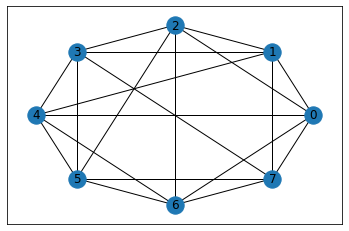

In [11]:
pos = nx.circular_layout(G_sol)
nx.draw_networkx(G_sol,pos=pos,with_labels=True)

In [12]:
print(maxAllowedEperNode)
print(calc_cost(G_sol,D))
print(x[0][5])

5.0
1.2857140800000013
[[<gurobi.Var x_(0, 5)_(0, 0) (value 0.0)>
  <gurobi.Var x_(0, 5)_(0, 1) (value 1.0)>
  <gurobi.Var x_(0, 5)_(0, 2) (value -0.0)>
  <gurobi.Var x_(0, 5)_(0, 3) (value -0.0)>
  <gurobi.Var x_(0, 5)_(0, 4) (value -0.0)>
  <gurobi.Var x_(0, 5)_(0, 5) (value 0.0)>
  <gurobi.Var x_(0, 5)_(0, 6) (value -0.0)>
  <gurobi.Var x_(0, 5)_(0, 7) (value -0.0)>]
 [<gurobi.Var x_(0, 5)_(1, 0) (value 1.0)>
  <gurobi.Var x_(0, 5)_(1, 1) (value 0.0)>
  <gurobi.Var x_(0, 5)_(1, 2) (value -0.0)>
  <gurobi.Var x_(0, 5)_(1, 3) (value -0.0)>
  <gurobi.Var x_(0, 5)_(1, 4) (value -0.0)>
  <gurobi.Var x_(0, 5)_(1, 5) (value 0.0)>
  <gurobi.Var x_(0, 5)_(1, 6) (value -0.0)>
  <gurobi.Var x_(0, 5)_(1, 7) (value -0.0)>]
 [<gurobi.Var x_(0, 5)_(2, 0) (value -0.0)>
  <gurobi.Var x_(0, 5)_(2, 1) (value -0.0)>
  <gurobi.Var x_(0, 5)_(2, 2) (value 0.0)>
  <gurobi.Var x_(0, 5)_(2, 3) (value -0.0)>
  <gurobi.Var x_(0, 5)_(2, 4) (value -0.0)>
  <gurobi.Var x_(0, 5)_(2, 5) (value 0.0)>
  <gurobi.Var x